In [1]:
include("../LiPoSID.jl")
using PyPlot

In [41]:
data_dir = "../DATA/"
γ_list = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133",  "79.477", "251.33"]

γ_list_disp = [ "0.0795",  "0.2513", "0.7947", "2.5133", "7.9477", "25.133",  "79.477", "251.33"]

function bloch4(ρ)

    b = convert.(Float64, [ ρ[1,2] + ρ[2,1],
                           (ρ[1,2] - ρ[2,1])*im,    #ρ[2,1] - ρ[1,2] ?
                            ρ[1,1] - ρ[2,2],
                               1                 ]) #ρ[1,1] + ρ[2,2]  

end

function dm_b4(b) 

    ρ = [ 1+b[3]         b[1]-im*b[2]
          b[1]+im*b[2]   1-b[3]       ]/2

end

function propagate_DMD_b4(A, ρ₀, lᵐᵃˣ)

    ρ = [ρ₀]

    for i in 2:lᵐᵃˣ
        push!(ρ, dm_b4( A * bloch4(ρ[end])))
    end

    return ρ

end

function DMD_step(A, ρ₀)
    dm_b4(A * bloch4(ρ₀))
end

max_neg(d) = minimum(d) < 0 ? abs(minimum(d)) : 0
sum_neg(d) = abs(sum(d[d .< 0]))


sum_neg (generic function with 1 method)

In [15]:
ρᵍ₀ = [1. 0]' * [1 0]
ρᵉ₀ = [0. 1]' * [0 1]
ρˣ₀ = [1  1]' * [1 1]/2
ρʸ₀ = [1 -im]' * [1 -im]/2

max_negs = []
sum_negs = []
num_negs = []

for γᵢ in γ_list 

    ρᵉ, tᵉ = LiPoSID.get_rho_series(data_dir*"State_B1_2CUT_data.h5", γᵢ)
    ρᵍ, tᵍ = LiPoSID.get_rho_series(data_dir*"State_B2_2CUT_data.h5", γᵢ)
    ρˣ, tˣ = LiPoSID.get_rho_series(data_dir*"State_B3_2CUT_data.h5", γᵢ)
    ρʸ, tʸ = LiPoSID.get_rho_series(data_dir*"State_B4_2CUT_data.h5", γᵢ)

    lᵉ = length(ρᵉ); lᵍ = length(ρᵍ); lˣ = length(ρˣ); lʸ = length(ρʸ)
    lᵐᵃˣ = min(lᵉ, lᵍ,  lˣ, lʸ)  #choose time limit by shortest series

    Aᴰᴹᴰ⁻ˢᴮ = LiPoSID.direct_DMD_01XY_b4_A([ρᵉ[1:lᵐᵃˣ], ρᵍ[1:lᵐᵃˣ], ρˣ[1:lᵐᵃˣ], ρʸ[1:lᵐᵃˣ]])

    ρᵍ₁ˢᴮ = DMD_step(Aᴰᴹᴰ⁻ˢᴮ, ρᵍ₀)
    ρᵉ₁ˢᴮ = DMD_step(Aᴰᴹᴰ⁻ˢᴮ, ρᵉ₀)
    ρˣ₁ˢᴮ = DMD_step(Aᴰᴹᴰ⁻ˢᴮ, ρˣ₀)
    ρʸ₁ˢᴮ = DMD_step(Aᴰᴹᴰ⁻ˢᴮ, ρʸ₀)

    Eᴰᴹᴰ⁻ˢᴮ, dˢᴮ = LiPoSID.QPT(ρᵍ₁ˢᴮ, ρᵉ₁ˢᴮ, ρˣ₁ˢᴮ, ρʸ₁ˢᴮ)

    push!(max_negs, max_neg(dˢᴮ))
    push!(sum_negs, sum_neg(dˢᴮ))
    push!(num_negs, count(x->x<0, dˢᴮ))

end

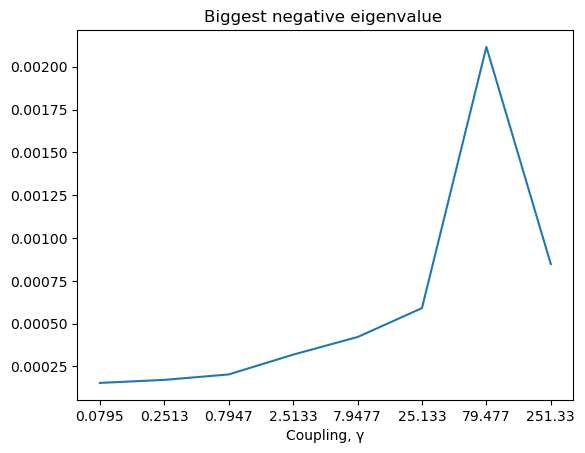

In [42]:
PyPlot.plot(max_negs)
PyPlot.title("Biggest negative eigenvalue ")
PyPlot.xlabel("Coupling, γ"); 
PyPlot.xticks(0:7, γ_list_disp )
PyPlot.show()
PyPlot.display_figs()


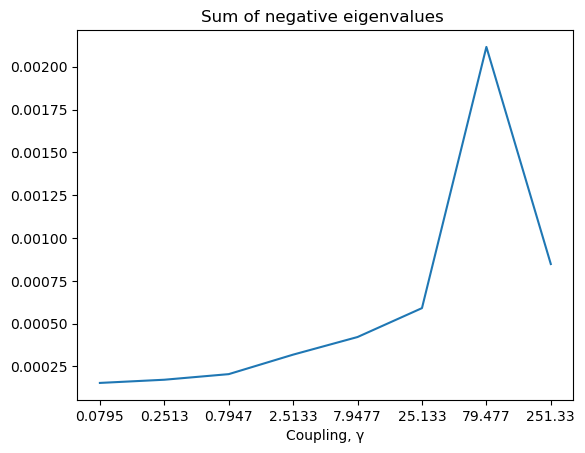

In [43]:
PyPlot.plot(sum_negs)
PyPlot.title("Sum of negative eigenvalues ")
PyPlot.xlabel("Coupling, γ"); 
PyPlot.xticks(0:7, γ_list_disp)
PyPlot.show()
PyPlot.display_figs()

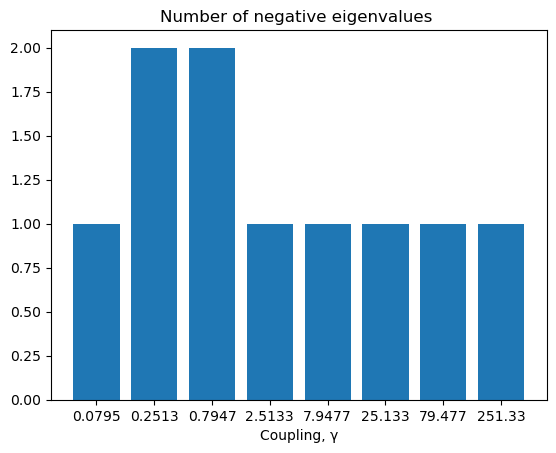

In [44]:
PyPlot.bar(0:7, num_negs)
PyPlot.title("Number of negative eigenvalues ")
PyPlot.xlabel("Coupling, γ"); 
PyPlot.xticks(0:7, γ_list_disp )
PyPlot.show()
PyPlot.display_figs()